In [1]:
import cv2
import os
import numpy as np

%matplotlib inline
from matplotlib import pyplot as plt

plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['figure.dpi'] = 180

plt.rcParams['figure.constrained_layout.use'] = True


## Load images

In [2]:
IMG_DIR = 'panorama_images'

files = list(map(lambda x: os.path.join(IMG_DIR, x), os.listdir(IMG_DIR)))
files.sort()
files

['panorama_images/1.jpg',
 'panorama_images/2.jpg',
 'panorama_images/3.jpg',
 'panorama_images/4.jpg']

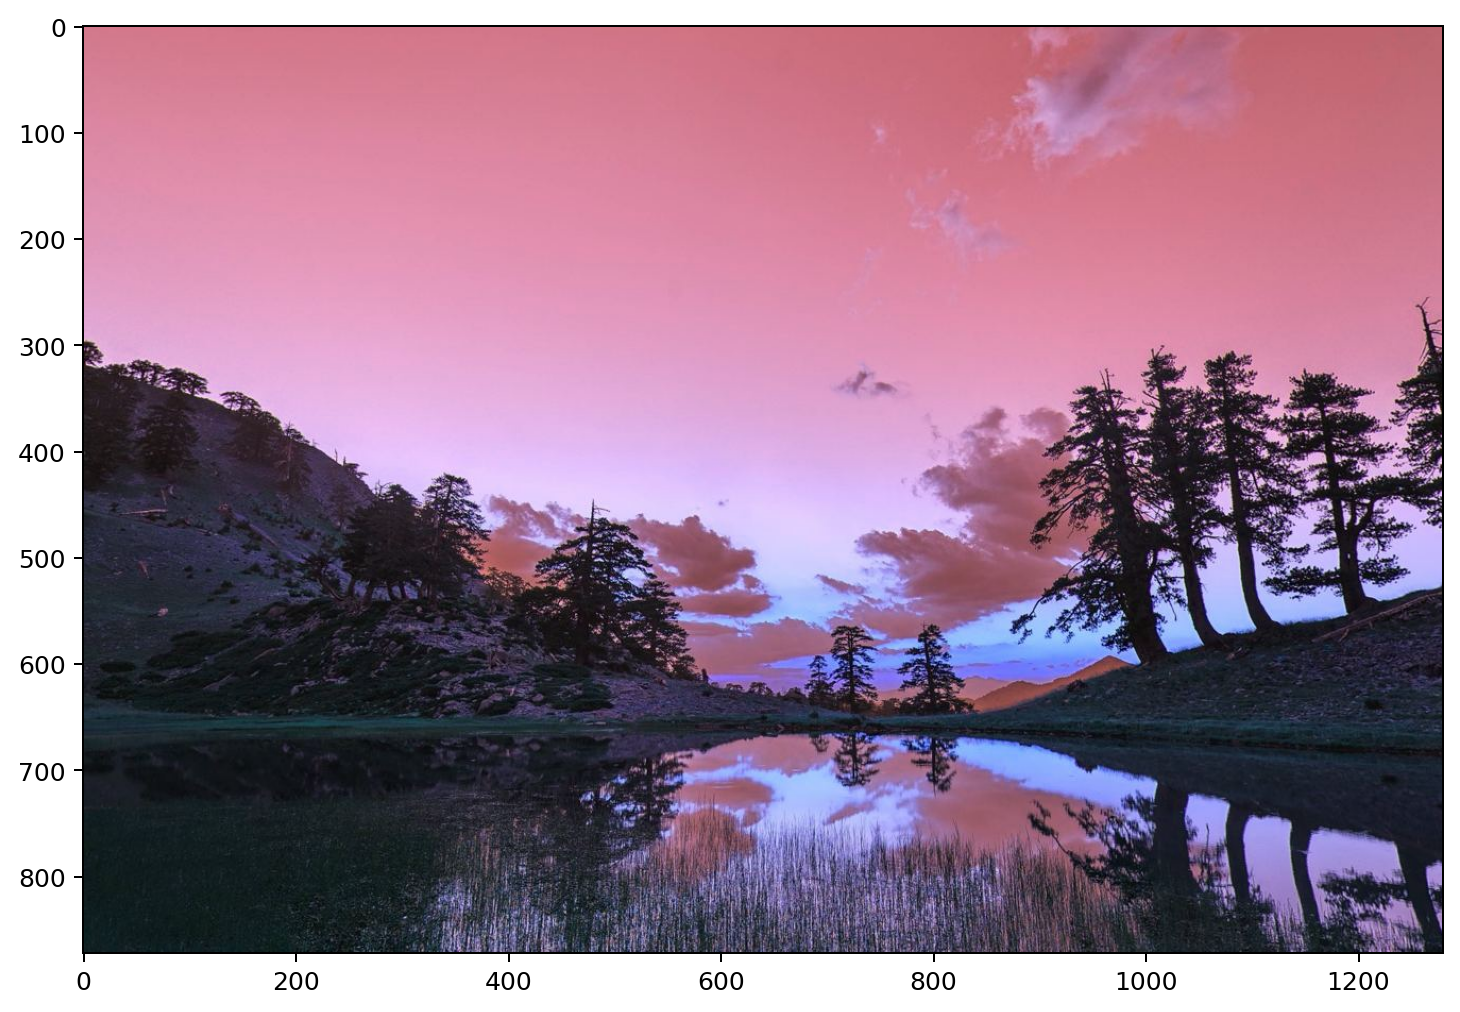

In [3]:
images = []
for filename in files:
    images.append(cv2.imread(filename))
        
plt.imshow(images[1])

## SIFT keypoints

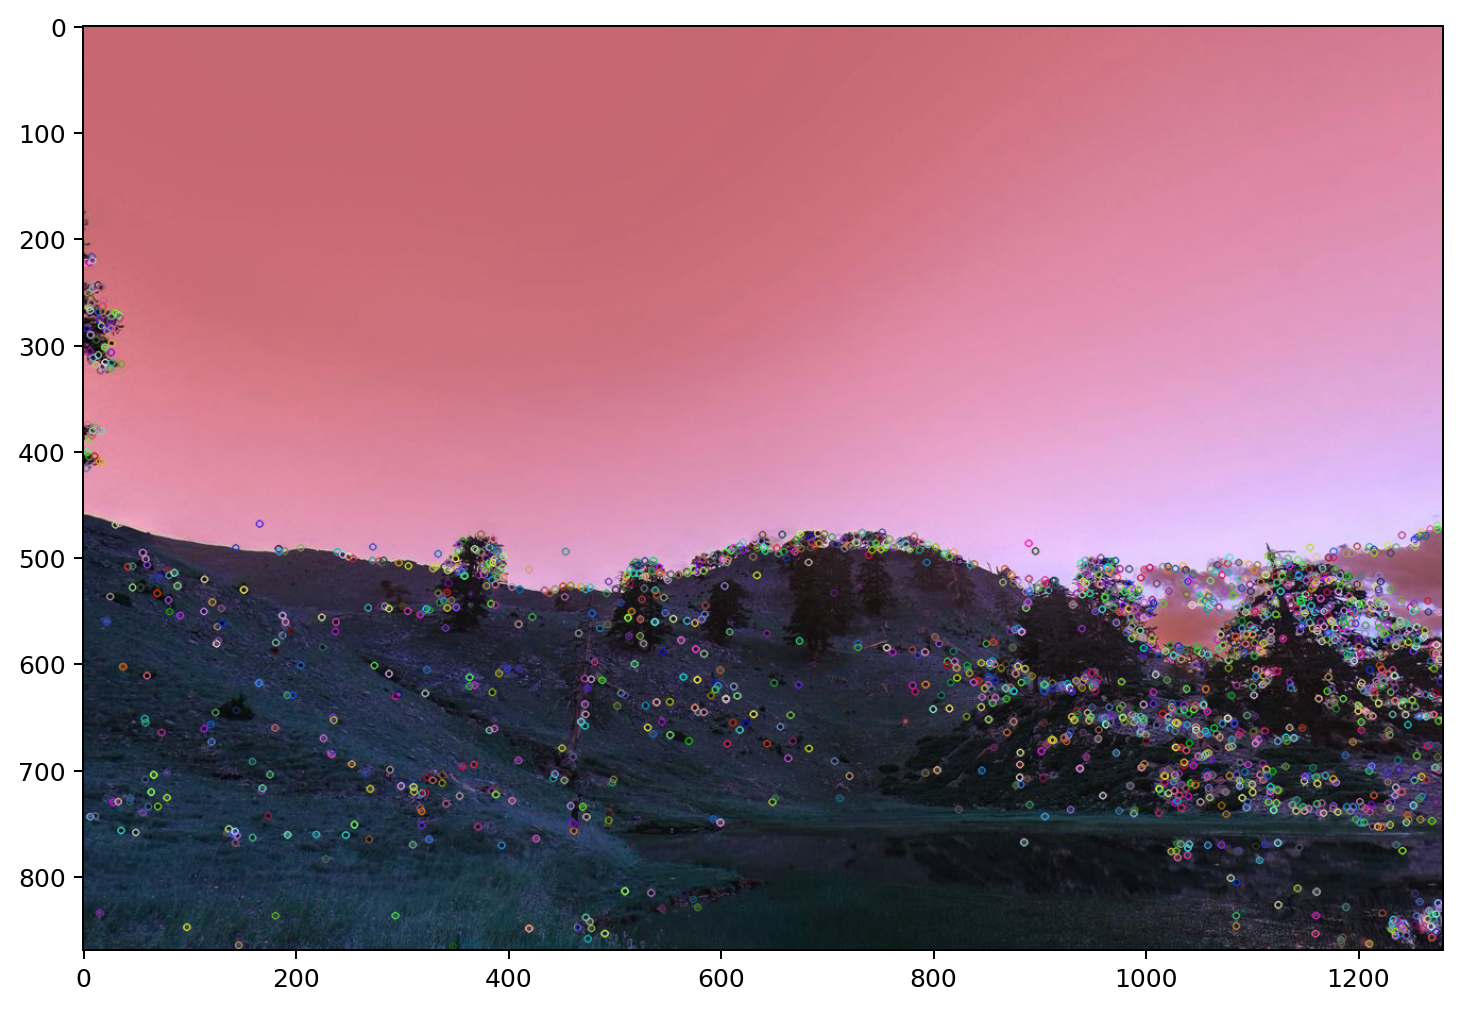

In [4]:
sift = cv2.xfeatures2d.SIFT_create()
keypoints, desc = sift.detectAndCompute(images[0], None)
drawn_kps= cv2.drawKeypoints(images[0], keypoints, None)
plt.imshow(drawn_kps)

## ORB keypoints

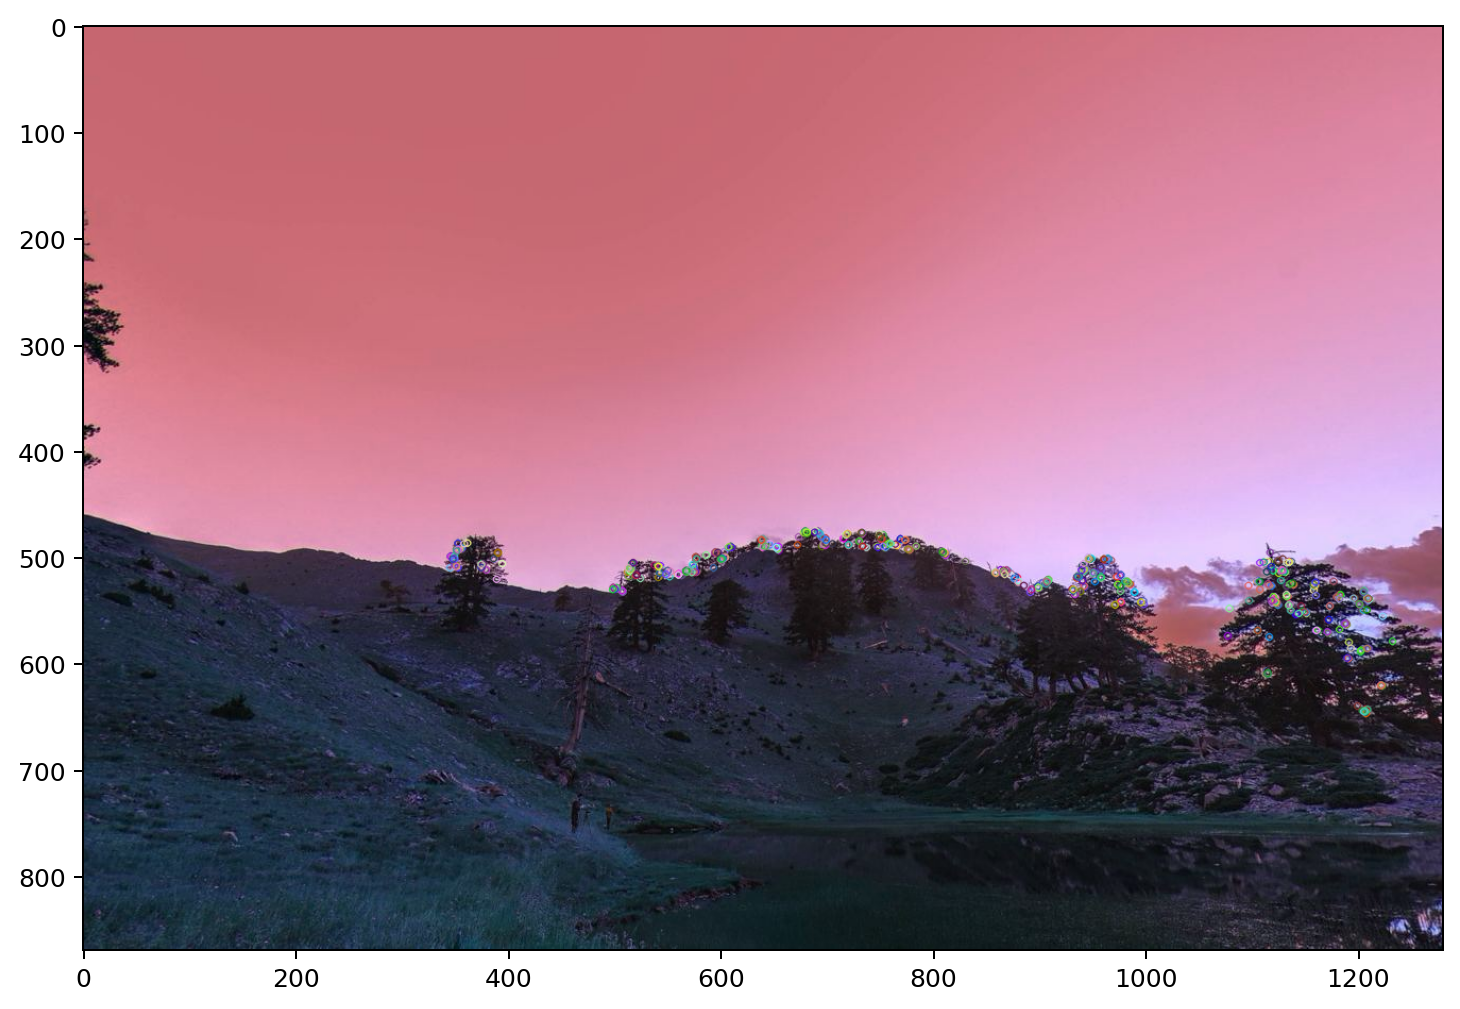

In [5]:
orb = cv2.ORB_create()
kps, dsc = orb.detectAndCompute(images[0], None)
drawn_kps = cv2.drawKeypoints(images[0], kps, None)
plt.imshow(drawn_kps)

## SIFT matching using bruteforce

In [6]:
a_kps, a_dsc = sift.detectAndCompute(images[0], None)
b_kps, b_dsc = sift.detectAndCompute(images[1], None)

In [7]:
bf = cv2.BFMatcher(cv2.NORM_L2SQR, crossCheck=True)

matches = list(bf.match(a_dsc, b_dsc))
matches.sort(key=lambda x: x.distance)

In [8]:
matches[0].distance, matches[0].trainIdx, matches[0].queryIdx, matches[0].imgIdx

(1254.0, 428, 901, 0)

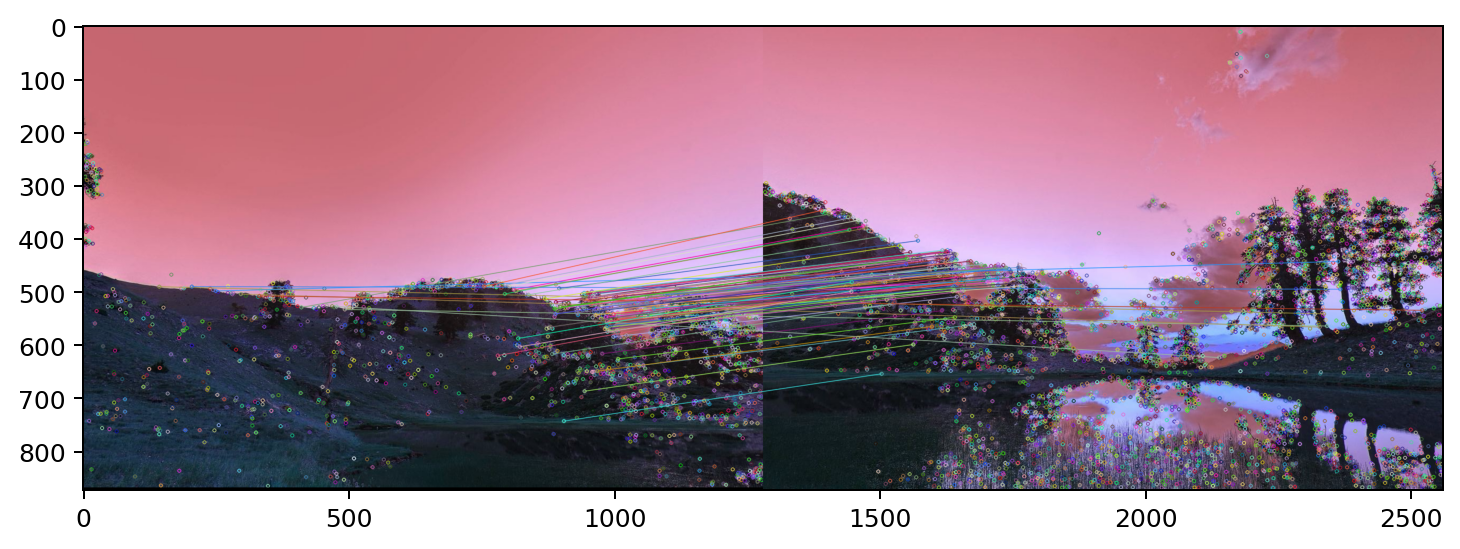

In [9]:
matched_image = cv2.drawMatches(images[0], a_kps,
                                images[1], b_kps,
                                matches[:100], None)
plt.imshow(matched_image)

# Panography

### Find the homography matrix and warp the images

In [10]:
image_a, image_b = images[1], images[0]

# recalc second image size
image_b.resize(image_a.shape, refcheck=False)

# recalc features
kps_a, dsc_a = sift.detectAndCompute(image_a, None)
kps_b, dsc_b = sift.detectAndCompute(image_b, None)

### Find matches between images descriptions
Using `k-nearest neighbours` matching

In [11]:
knn_matcher = cv2.DescriptorMatcher_create('BruteForce')
knn_matches = knn_matcher.knnMatch(dsc_a, dsc_b, 2)
print(len(knn_matches))

4901


Default ratio filtering

In [12]:
matches = []
for m, n in knn_matches:
    if m.distance < n.distance * 0.75:
        matches.append(m)

In [13]:
len(matches)

484

### Calculate homography between images

In [14]:
pts_a = np.float32([kps_a[m.queryIdx].pt for m in matches])
pts_b = np.float32([kps_b[m.trainIdx].pt for m in matches])

h_matrix, _ = cv2.findHomography(pts_a, pts_b, cv2.RANSAC, 4.0)
h_matrix

array([[-5.55206730e-02, -5.08667682e-03,  6.45356207e+02],
       [-5.31060275e-01,  5.30697098e-01,  2.87862824e+02],
       [-7.27946623e-04, -2.17601299e-04,  1.00000000e+00]])

### Apply homography matrix onto image

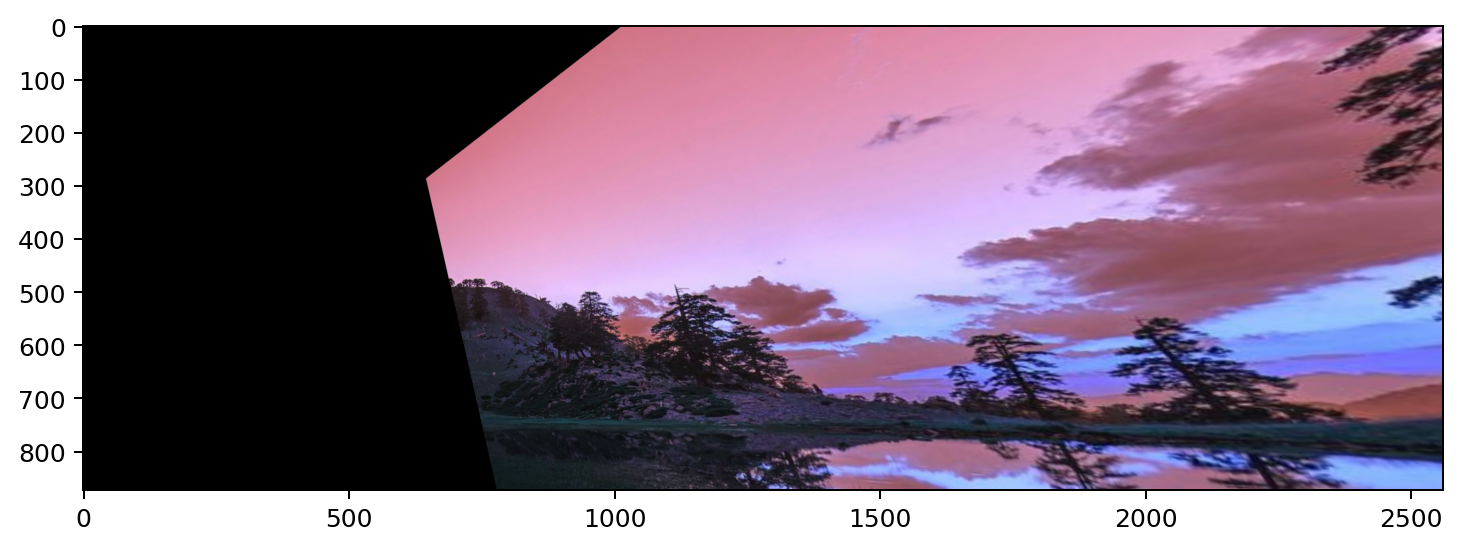

In [15]:
result_image = cv2.warpPerspective(image_a, h_matrix,
                                  (image_a.shape[1] + image_b.shape[1], image_a.shape[0]))

plt.imshow(result_image)

### Result panography image

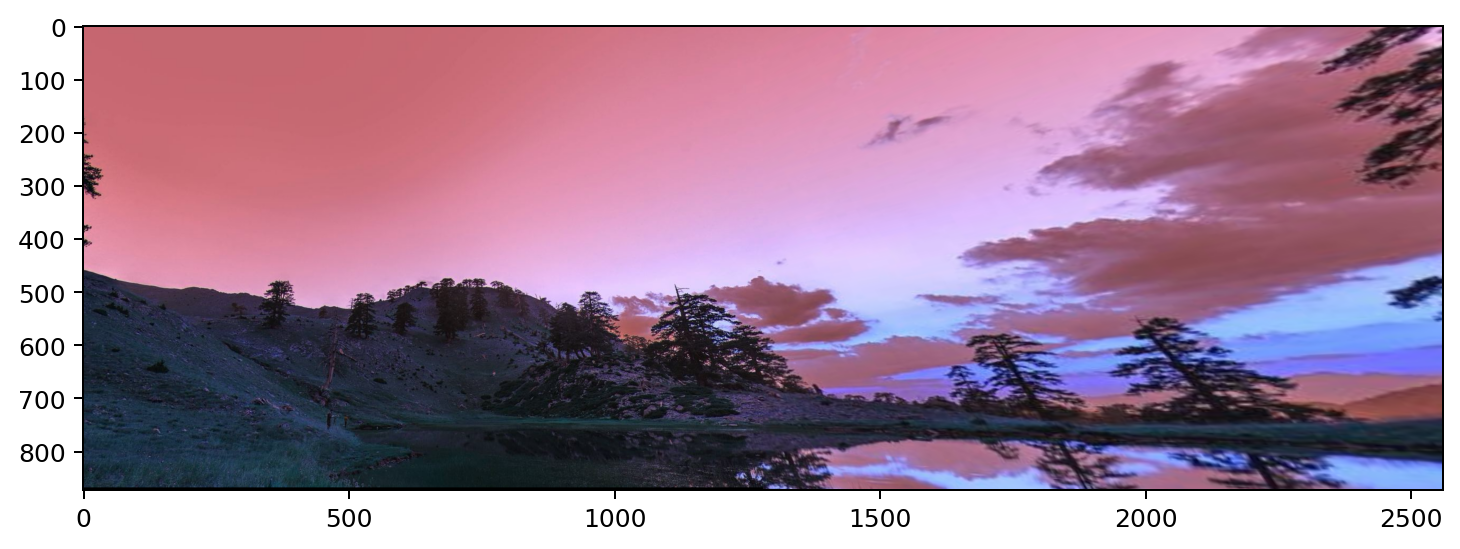

In [16]:
result_image[0:image_b.shape[0], 0:image_b.shape[1]] = image_b
plt.imshow(result_image)